# *Quantum Teleportation*

This notebook implements the quantum teleportation protocol using the [Quantum Experience](https://www.research.ibm.com/ibm-q/qx/).

## Introduction

Quantum teleportation is a protocol to transmit quantum states from one location to another, assisted by previously shared entangled states and a classical communication channel. It was devised by Charles H. Bennett (IBM), Gilles Brassard, Claude Crépeau, Richard Jozsa, Asher Peres and William K. Wootters in [1993](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895). It was first demonstrated with photons in [1997](http://www.nature.com/nature/journal/v390/n6660/abs/390575a0.html), and has since been realised in [atoms](http://www.nature.com/nphys/journal/v9/n7/abs/nphys2631.html), [ions](http://www.nature.com/nature/journal/v429/n6993/full/nature02570.html, http://www.nature.com/nature/journal/v429/n6993/full/nature02608.html), [electrons](http://science.sciencemag.org/content/345/6196/532) and [superconducting circuits](http://www.nature.com/nature/journal/v500/n7462/full/nature12422.html). The [record](http://www.nature.com/nature/journal/v489/n7415/full/nature11472.html) distance for quantum teleportation is 143km in 2012 via satellite.

The protocol starts out with a shared entangled state between the sender (Alice) and the receiver (Bob):
$$|\psi\rangle_{AB} = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B)$$
The first qubit, denoted by subscript $A$, belongs to Alice and the second qubit, $B$, belongs to Bob.

Alice has a quantum state, that she wants to convey to Bob:
$$|\psi\rangle_{C} = \alpha|0\rangle_C + \beta|1\rangle_C$$

At this point, Alice has two quantum states ($C$, the one she wants to teleport, and $A$, one of the entangled pair), and Bob has one quantum state. The total state of the system is given by:
$$|\psi\rangle_{AB} \otimes |\psi\rangle_C = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B) \otimes (\alpha|0_C\rangle + \beta|1_C\rangle)$$
or, in the Bell basis:
$$|\psi\rangle_{AB} \otimes |\psi\rangle_C = \frac{1}{2}[
|\Phi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B) + 
|\Phi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B) + \\
|\Psi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B) + 
|\Psi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B) ]$$
where:
$$|0\rangle \otimes |0\rangle = \frac{1}{\sqrt{2}}(|\Phi^+\rangle + |\Phi^-\rangle), 
|0\rangle \otimes |1\rangle = \frac{1}{\sqrt{2}}(|\Psi^+\rangle + |\Psi^-\rangle)\\
|1\rangle \otimes |0\rangle = \frac{1}{\sqrt{2}}(|\Psi^+\rangle - |\Psi^-\rangle), 
|1\rangle \otimes |1\rangle = \frac{1}{\sqrt{2}}(|\Phi^+\rangle - |\Phi^-\rangle)$$

Alice now measures the her two quantum states, $A$ and $C$ in the Bell basis. This will collapse the three state system into the one of the following four states with equal probability:
- $|\Phi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B)$
- $|\Phi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B)$
- $|\Psi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B)$ 
- $|\Psi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B)$

Alice's two states are now entangled to each other, and the entanglement originally shared between Alice's and Bob's states is now broken. Note how Bob's qubit is now in a state that resembles the state to be teleported. 

The result of Alice's measurement tells her which of the above four states the system is in, $|\Phi^+\rangle_{AC}, |\Phi^-\rangle_{AC}, |\Psi^-\rangle_{AC}$ or $|\Psi^-\rangle_{AC}$. She now sends her result to Bob through a classical channel. Two classical bits can communicate which of the four results she obtained.

After Bob receives the message from Alice, he will know which of the four states his particle is in. Using this information, he performs a unitary operation on his particle to transform it to the desired state $\alpha|0\rangle_B - \beta|1\rangle_B$:
- If he receives $|\Phi^+\rangle_{AC}$: Bob applies $I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$ to his quantum state. 
- If he receives $|\Phi^-\rangle_{AC}$: Bob applies $X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$ to his quantum state. 
- If he receives $|\Psi^+\rangle_{AC}$: Bob applies $Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$ to his quantum state. 
- If he receives $|\Psi^-\rangle_{AC}$: Bob applies $XZ = \begin{bmatrix} 0 & -1 \\ 1 & 0 \end{bmatrix}$ to his quantum state. 

Teleportation of $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ is thus achieved. 

## Implementation
The first step is to import the required packages, initialise the Quantum Experience API, and start creating the [QASM](https://github.com/IBM/qiskit-openqasm) script as a string, which  will run on the quantum processor. 

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")

import numpy as np
import time

from IBMQuantumExperience import IBMQuantumExperience
from qhelpers.basicplotter import plot_histogram
from qhelpers.misc import get_data
from qhelpers.misc import combine_jobs
from qhelpers.misc import average_data

import Qconfig
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken,Qconfig.config)

teleportation_code = """
OPENQASM 2.0;
include "qelib1.inc";
"""

To make the shared entangled state $|\psi\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$:
1. Start with an initial state $|0_A 0_B\rangle$
2. Apply $H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$ on $q_A$ 
3. Then a $CNOT = \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\0& 0& 1 & 0\\0 & 1 & 0 & 0 \end{bmatrix}$ from $q_A$ to $q_B$

In QASM, with $q_A = q_1$ and $q_B = q_2$, this looks like:

In [2]:
teleportation_code += """
qreg q[3];
creg c0[1];
creg c1[1];
creg c2[1];

h q[1];
cx q[1],q[2];
barrier q;
"""

Alice then prepares her quantum state to be teleported, $|\psi\rangle_{C} = \alpha|0\rangle_C + \beta|1\rangle_C$. In this experiment, $\alpha = \cos(\theta/2)$ and $\beta = \sin(\theta/2)$ where $\theta = \pi/4$. This state can be created by applying:
1. $H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$ on $q_C$
2. Followed by $T = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{bmatrix}$
3. Followed by another $H$
4. Followed by $S = \begin{bmatrix} 1 & 0 \\ 0 & i \end{bmatrix}$

In QASM, with $q_C = q_0$, this looks like:

In [3]:
teleportation_code += """
h q[0];
t q[0];
h q[0];
s q[0];
barrier q;
"""

Alice now applies $CNOT$ to her two quantum states $q_A(q_1)$ and $q_C(q_0)$, followed by an H, to entangle them and project them into the Bell basis:

In [4]:
teleportation_code += """
cx q[0],q[1];
h q[0];
"""

She now measures her two quantum states $q_A(q_1)$ and $q_C(q_0)$:

In [5]:
teleportation_code += """
measure q[0] -> c0[0];
measure q[1] -> c1[0];
"""

Depending on the results of these measurements, Bob has to apply an $X$ or $Z$ or both:

In [6]:
teleportation_code += """
if(c0==1) z q[2];
if(c1==1) x q[2];
"""

His state is now the same as the state Alice prepared earlier, which can be verified by measurement:

In [7]:
teleportation_code += """
measure q[2] -> c2[0];
"""

print(teleportation_code)


OPENQASM 2.0;
include "qelib1.inc";

qreg q[3];
creg c0[1];
creg c1[1];
creg c2[1];

h q[1];
cx q[1],q[2];
barrier q;

h q[0];
t q[0];
h q[0];
s q[0];
barrier q;

cx q[0],q[1];
h q[0];

measure q[0] -> c0[0];
measure q[1] -> c1[0];

if(c0==1) z q[2];
if(c1==1) x q[2];

measure q[2] -> c2[0];



Let's now run the QASM code on the simulator (there is currently an [issue](https://github.com/IBM/qiskit-sdk-py/issues/2) running this code on the real device):

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (5 seconds)


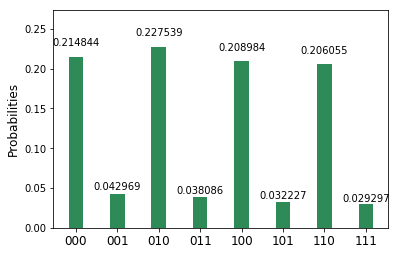

In [8]:
qasms = [{'qasm' : teleportation_code}]
out = api.run_job(qasms,'simulator',1024,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=5, timeout=240)
data=get_data(results,0)
plot_histogram(data)

Need to manipulate the data to understand these results better, first only plotting the results of Alice's measurement: 

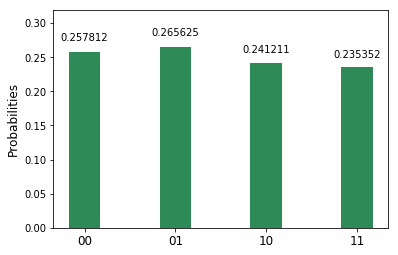

In [9]:
alice = {}
alice['00'] = data['000'] + data['001']
alice['01'] = data['010'] + data['011']
alice['10'] = data['100'] + data['101']
alice['11'] = data['110'] + data['111']
plot_histogram(alice)

As expected, the probabilities are roughly equal.  

Now, manipulate the data to plot the result of Bob's measurement:

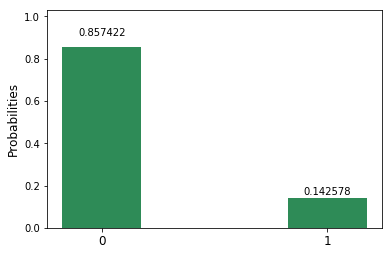

In [10]:
bob = {}
bob['0'] = data['000'] + data['010'] +  data['100'] + data['110']
bob['1'] = data['001'] + data['011'] +  data['101'] + data['111']
plot_histogram(bob)

As expected $|\alpha|^2 = |\cos(\pi/8)|^2 \approx 0.85$ (the probably of measuring 0) and $|\beta|^2 = |\sin(\pi/8)|^2 \approx 0.15$ (the probability of measuring 1).